In [1]:
import sys
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from accelerate import DataLoaderConfiguration
from accelerate import Accelerator
import wandb

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_dir = os.path.abspath('')

dna_diff_path = os.path.join(file_dir, '..', '..','re_design', 'DNA-Diffusion', 'src')
train_utils_path = os.path.join(file_dir,'..','train_utils')
data_dir = os.path.join(file_dir, '..','data_preprocessing','generated_data')
save_dir =  os.path.join(file_dir,'train_output')

if dna_diff_path not in sys.path:
    sys.path.append(dna_diff_path)

if train_utils_path not in sys.path:
    sys.path.append(train_utils_path)

In [3]:
from dnadiffusion.models.diffusion import Diffusion
from dnadiffusion.models.unet import UNet
from utils import (
    extract_motifs,
    compare_motif_list,
    kl_heatmap,
    generate_heatmap,
    plot_training_loss,
    plot_training_validation
)

from utils_data import load_TF_data

from dna_tools import (
    TrainLoop
)

In [4]:
class ModelParameters:
    datafile = f'{data_dir}/tcre_seq_motif_cluster.csv'
    device = 'cuda'
    batch_size = 32 #960
    num_workers = 8
    seq_length = 200
    subset = None
    num_epochs = 50 # 2000
    log_step_show=5 # 500
    sample_epoch=5 # 500
    save_epoch=5 # 500
    num_sampling_to_compare_cells = 100
    
# weights and presampled noise
config = ModelParameters()

In [5]:
data = load_TF_data(
    data_path=config.datafile,
    seqlen=config.seq_length,
    limit_total_sequences=config.subset,
    num_sampling_to_compare_cells=config.num_sampling_to_compare_cells,
    to_save_file_name="cre_encode_data_motif_cluster",
    saved_file_name="cre_encode_data_motif_cluster.pkl",
    load_saved_data=False,
)


Generating Motifs and Fastas... train
------------------------------
Cell_type  ct1
Cell_type  ct2
Cell_type  ct3
Generating Motifs and Fastas... test
------------------------------
Cell_type  ct1
Cell_type  ct2
Cell_type  ct3
Generating Motifs and Fastas... shuffled
------------------------------
Cell_type  ct1
Cell_type  ct2
Cell_type  ct3


In [6]:
compare_motif_list(data['train_motifs'],data['test_motifs'])

0.08004166328935579

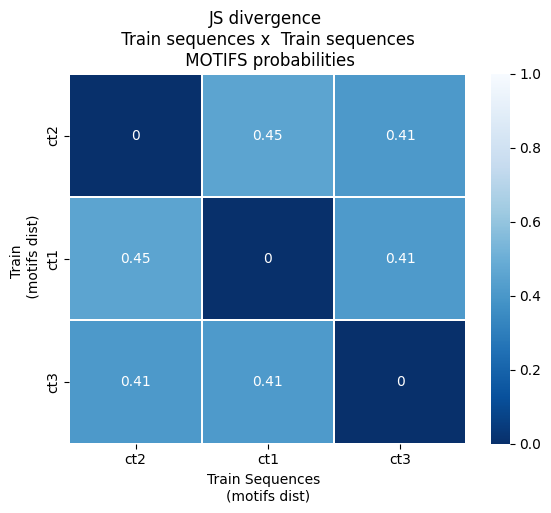

In [7]:
cell_list = list(data["numeric_to_tag"].values())

motif_df = kl_heatmap(
    data['train_motifs_cell_specific'],
    data['train_motifs_cell_specific'],
    cell_list
)
generate_heatmap(motif_df, "Train", "Train", cell_list)

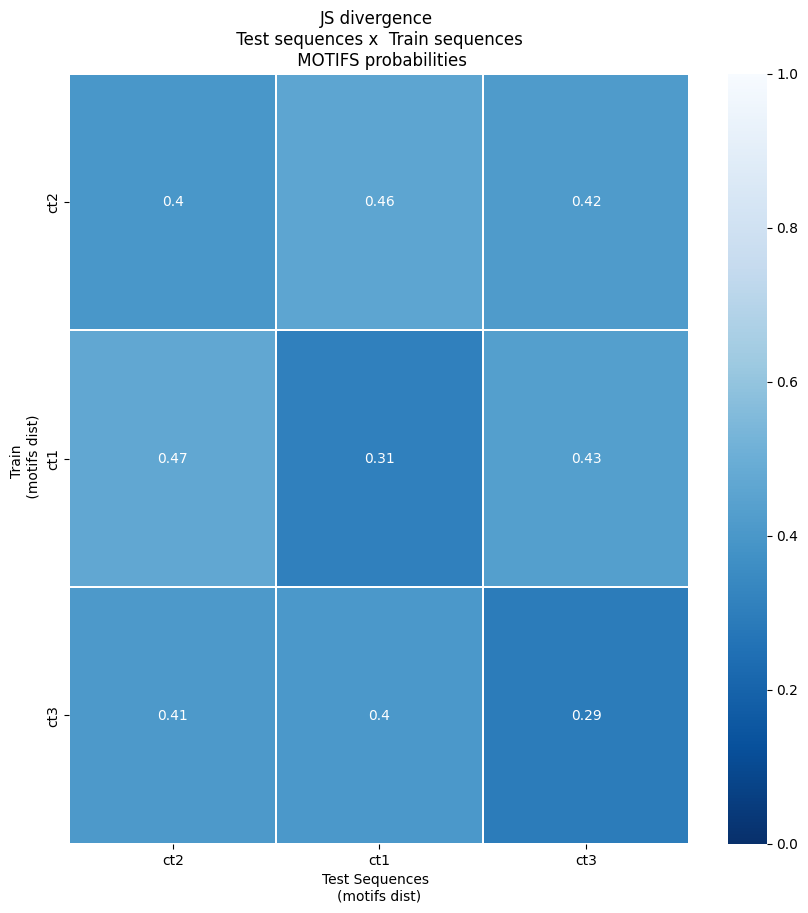

In [8]:
motif_df = kl_heatmap(
    data['test_motifs_cell_specific'],
    data['train_motifs_cell_specific'],
    cell_list
)
generate_heatmap(motif_df, "Test", "Train", cell_list)

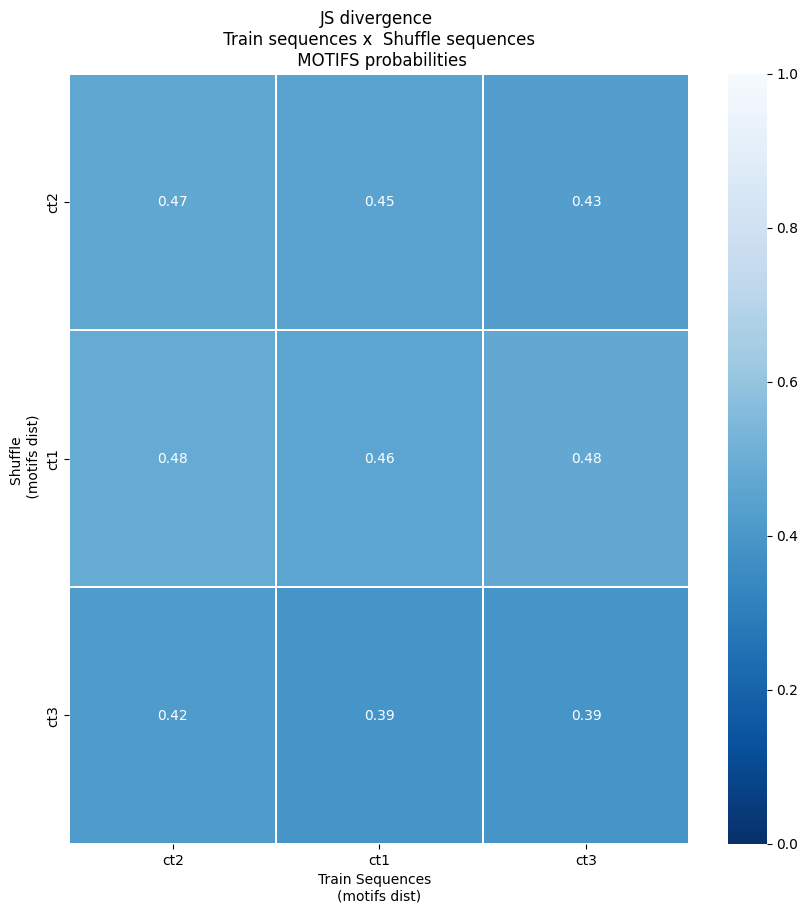

In [9]:
motif_df = kl_heatmap(
    data['train_motifs_cell_specific'],
    data['shuffle_motifs_cell_specific'],
    cell_list
)
generate_heatmap(motif_df, "Train", "Shuffle", cell_list)

The main diffusion model was implemented in PyTorch 2.0.0 and trained on 4x 40gb Nvidia A100s using a batch size of 960 for 2000 epochs. For distributed computing across the nodes we employed Slurm Workload Manager. We used the Adam optimizer (reference) with a learning rate of 1e-4 along with PyTorch default values for other hyperparameters: β1=0.9 and β2=0.999. Linear noising schedule was used with βstart=0.0001 and βend=0.005.

In [11]:
from dnadiffusion.models.diffusion import Diffusion
from dnadiffusion.models.unet import UNet
from utils import TrainLoop

dataloader_config = DataLoaderConfiguration(split_batches=True)
device_cpu = config.device == "cpu"
accelerator = Accelerator(dataloader_config =dataloader_config, cpu=device_cpu, mixed_precision="fp16")


unet = UNet(
        dim=200,
        channels=1,
        dim_mults=(1, 2, 4),
        resnet_block_groups=8
    )

diffusion = Diffusion(
    unet,
    timesteps=50,
)

trainloop = TrainLoop(
    config=config,
    data = data,
    model=diffusion,
    accelerator=accelerator,
    epochs=config.num_epochs,
    log_step_show=config.log_step_show,
    sample_epoch=config.sample_epoch,
    save_epoch=config.save_epoch,
    model_name="model_PBMC_3k_3cluster_tcre",
    num_sampling_to_compare_cells=config.num_sampling_to_compare_cells
)
trainloop.train_loop()

# trainloop.load("checkpoints/epoch_1000_model_PBMC_3k_3cluster_tcre.pt")

  0%|          | 0/50 [00:00<?, ?it/s]/root/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
  0%|          | 0/50 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
cell_num_list = data['cell_types']
nucleotides = ["A", "C", "G", "T"]
cond_weight_to_metric = 1
save_dataframe = True
sample_bs = 10
num_samples = 10 # config.num_sampling_to_compare_cells
generated_celltype_motif = {}
# iterate over cell types
for cell_num in cell_num_list:
    cell_type = data['numeric_to_tag'][cell_num]
    print(f"Generating {num_samples*10} samples for cell_type {cell_type}")
    final_sequences = []
    for n_a in range(num_samples):
        sampled = torch.from_numpy(np.array([cell_num] * sample_bs))
    
        classes = sampled.float().to(diffusion.device)
        # generate images (time_steps, sample_bs, 1, 4, 200)
        sampled_images = diffusion.sample(classes, (sample_bs, 1, 4, 200), cond_weight_to_metric)
        # iterate over last (clear) images
        for n_b, x in enumerate(sampled_images[-1]):
            # prepare for fasta and trasform from one-hot to nucletides
            seq_final = f">seq_test_{n_a}_{n_b}\n" + "".join(
                [nucleotides[s] for s in np.argmax(x.reshape(4, 200), axis=0)]
            )
            final_sequences.append(seq_final)
        # extract motifs from generated sequences
    df_motifs_count_syn = extract_motifs(final_sequences)
    generated_celltype_motif[cell_type] = df_motifs_count_syn
    

Finished generating heatmaps


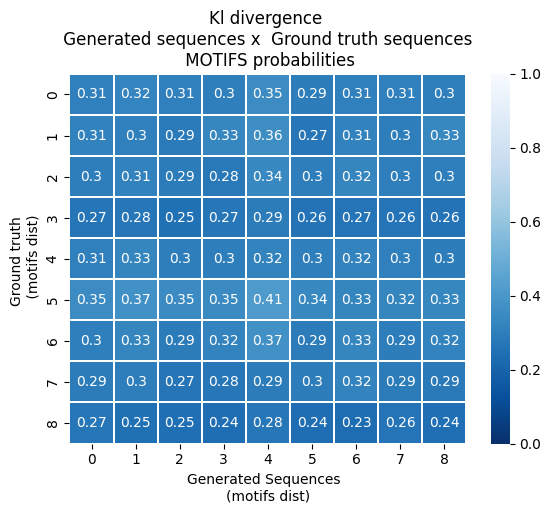

In [ ]:
# Generate synthetic vs synthetic heatmap
motif_df = kl_heatmap(
    generated_celltype_motif,
    generated_celltype_motif,
    cell_list
)
generate_heatmap(motif_df, "Generated", "Generated", cell_list)

# Generate synthetic vs train heatmap
motif_df = kl_heatmap(
    generated_celltype_motif,
    data['train_motifs_cell_specific'],
    cell_list
)
generate_heatmap(motif_df, "Generated", "Ground truth", cell_list)

print("Finished generating heatmaps")


In [ ]:
accelerator.end_training()